# Introduction

To collect the transaction data on r/gameswap and r/gamesale.

## 0. Load the packages

In [1]:
import json
import pickle
import requests
import re
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from time import sleep
from bs4 import BeautifulSoup as bs

## 1. Plot the number of members.
Since Reddit does not provide the history of the number of members in each community, we proceed to [Wayback Machine](http://web.archive.org/), which provides snapshots for websites. Then we can extract the number of members from the snapshots of [r/gameswap](https://www.reddit.com/r/gameswap/) and [r/gamesale](https://www.reddit.com/r/gamesale/).

### 1.1 Gamesale

In [2]:
if not os.path.exists('data/gamesale.pickle'):
# Create a list month by month from 2013 to 2023 with the format of YYYYMMDD
    month_list = [str(year) + str(month).zfill(2) + '01' for year in range(2012, 2024) for month in range(1, 13)][11:-9]

    base = "http://web.archive.org/web/%s000000id_/https://www.reddit.com/r/gamesale/"
    archive_url_list = []
    for month in month_list:
        # Get the html
        print(month)
        html = requests.get(base % month).url
        print(html)
        archive_url_list.append(html)
        sleep(0.2)

    # Get the unique url in archive_url_list
    archive_url_list = sorted(list(set(archive_url_list)))

    archive_html_list = []
    for archive_url in archive_url_list:
        print(archive_url)
        archive_html_list.append(requests.get(archive_url).text)
        sleep(0.2)

    # Save the archive_html_list using pickle
    with open('archive_html_list_sale.pickle', 'wb') as f:
        pickle.dump(archive_html_list, f)

    # Parse the archive_html_list with bs4
    archive_html_list = [bs(x, 'html.parser') for x in archive_html_list]

    # Get the number in the class number
    temp = [x.find_all('span', class_='number') for x in archive_html_list]

    # Find the number like 10.1k
    pattern = r"\d+(?:\.\d+)?k\\n"
    store = []
    for html in archive_html_list[28:]:
        matches = re.findall(pattern, str(html.prettify ("utf-8")))
        store.append(matches)

    for i in range(len(store)):
        if len(store[i]) == 0:
            store[i] = [0]
        else:
            store[i] = [int(float(x.replace('k\\n', ''))*1000) for x in store[i]]


    # Get number from temp list
    pattern = r"\d+(?:\,\d+)?"
    num_list = []
    for x in temp[:28]:
        matches = re.findall(pattern, str(x))
        num_list.append(matches[0])
    # Replace , by '' for all the string in the sublist and convert to int
    num_list = [int(x.replace(',', '')) for x in num_list]

    total_members = num_list+ [x[0] for x in store]

    # Get the YYYYMMDD from the archive_url_list
    date = [re.findall(r'\d{8}', x)[0] for x in archive_url_list]
    date_members = list(zip(date, total_members))
    transformed_data = dict(date_members)

    # Drop the values that are 0
    transformed_data = {k: v for k, v in transformed_data.items() if v != 0}

    # Save the transformed_data using pickle
    with open('data/gamesale.pickle', 'wb') as f:
        pickle.dump(transformed_data, f)
else:
    with open('data/gamesale.pickle', 'rb') as f:
        date_members_sale = pickle.load(f)

### 1.2 Gameswap

In [3]:
if not os.path.exists('data/date_members_dict_processed.pickle'):
    month_list = [str(year) + str(month).zfill(2) + '01' for year in range(2009, 2024) for month in range(1, 13)]

    base = "http://web.archive.org/web/%s000000id_/https://www.reddit.com/r/gameswap/"
    archive_url_list = []
    for month in month_list:
        # Get the html
        print(month)
        html = requests.get(base%month).url
        print(html)
        archive_url_list.append(html)

    # Get the unique url in archive_url_list
    archive_url_list = list(set(archive_url_list))

    # Get the html from archive_url_list
    archive_html_list = []
    for archive_url in archive_url_list:
        print(archive_url)
        archive_html_list.append(requests.get(archive_url).text)

    # Sort the archive_html_list by the date
    archive_html_list = [x for _, x in sorted(zip(archive_url_list, archive_html_list))]
    archive_url_list.sort()

    # Get the YYYYMMDD from the archive_url_list
    date = [re.findall(r'\d{8}', x)[0] for x in archive_url_list]


    # Get the max from the values
    members = [x if x is not None else ['0'] for x in temp.values() ]

    # Replace , by '' for all the string in the sublist and convert to int
    members = [[int(x.replace(',', '')) for x in sublist] for sublist in members]
    # Get the max from the sublist
    max_members = [max(sublist) for sublist in members]


    date_members = list(zip(date, max_members))
    # Save the date_members using pickle
    with open('data/date_members.pickle', 'wb') as f:
        pickle.dump(date_members, f)

    # Get the date and max_members from the date_members where the max_members is 0
    b=[x for x in date_members if x[1] == 0]
    a = [0, 29167, 29667,30918,32071,33352,34374,35842,37340,38396,39490,40222,44700,45200,46300,46900,47600,48200,48800,49300]+[49800,49900,51100,51200,51400,52000,52300,52500,58600,58800,59000,59400,60100]

    adict = {}

    # date_members to dict
    date_members = dict(date_members)
    for dm, num in zip(b, a):
        date_members[dm[0]] = num
    date_members.pop('20160301')

    # Save date_members to pickle
    with open('data/date_members_dict_processed.pickle', 'wb') as f:
        pickle.dump(date_members, f)
else:
    # Load date_members from pickle
    with open('data/date_members_dict_processed.pickle', 'rb') as f:
        date_members_swap = pickle.load(f)

### 1.3 Get the game console release date

In [4]:
from igdb.wrapper import IGDBWrapper
post_url = "https://id.twitch.tv/oauth2/token?client_id=4njc2nod9cdh7wgc575ymsij8x7pli&client_secret=2g238v7i8bk5rrch8wn3g3eg45mcgq&grant_type=client_credentials"
req = requests.post(post_url)
req_dict = req.json()

wrapper = IGDBWrapper("4njc2nod9cdh7wgc575ymsij8x7pli",req_dict.get('access_token'))

# Get all the platforms
if not os.path.exists('./data/platforms.pickle'):
    platforms = []
    while True:
        try:
            byte_array = wrapper.api_request(
                'platforms',
                'fields *;offset %d; limit 500;'%(i*500)
            )
            time.sleep(0.25)
            platform_get = json.loads(byte_array)
            if platform_get:
                platforms += platform_get
            else:
                break
        except:
            break


    # Save the platforms
    with open('./data/platforms.pickle', 'wb') as handle:
        pickle.dump(platforms, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./data/platforms.pickle', 'rb') as handle:
        platforms = pickle.load(handle)

def get_version(version_id):
    byte_array = wrapper.api_request(
            'platform_versions',
            'fields * ; where id=%d;'%version_id
        )
    time.sleep(0.25)
    return json.loads(byte_array)[0]

def get_release_dates(platform_version_release_date_id):
    byte_array = wrapper.api_request(
        'platform_version_release_dates',
        'fields * ; where id=%d;'%platform_version_release_date_id
    )
    time.sleep(0.25)
    return json.loads(byte_array)[0]

if not os.path.exists('./data/version.pickle'):
    version_dict = {}
    for platform in platforms:
        # Get the version
        try:
            version_list = []
            for version_id in platform['versions']:
                version = get_version(version_id)
                version_list.append(version)
            version_dict[platform['name']] = version_list
            print(platform['name'])
        except:
            pass

    # Save the version
    with open('./data/version.pickle', 'wb') as handle:
        pickle.dump(version_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./data/version.pickle', 'rb') as handle:
        version_dict = pickle.load(handle)

# Choose the platform with category 1 or 5
console_dict = {}
for platform in platforms:
    try:
        if platform['category'] in [1,5]:
            console_dict[platform['name']] = version_dict[platform['name']]
    except:
        pass


In [5]:
if not os.path.exists('./data/console_date.pickle'):
    console_date_dict = {}
    for console_name, console_versions in console_dict.items():
        print(console_name)
        for version in console_versions:
            try:
                date = get_release_dates(version['platform_version_release_dates'][-1])
                console_date_dict[console_name+'-'+version['name']] = date
                print(console_name+'-'+version['name'])
            except:
                pass
    with open('./data/console_date.pickle', 'wb') as handle:
        pickle.dump(console_date_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./data/console_date.pickle', 'rb') as handle:
        console_date_dict = pickle.load(handle)

In [6]:
# Change to dataframe
df_console_date = pd.DataFrame.from_dict(console_date_dict, orient='index')
# Change the date to datetime
df_console_date['date'] = pd.to_datetime(df_console_date['date'], unit='s')
# Choose the date after 2009
df_console_date = df_console_date[df_console_date['date'] > '2009-01-01']

# Save the dataframe
df_console_date.to_csv('./data/console_date.csv')

### 1.4 Plot

In [7]:
game_console_interested = ['Nintendo Switch-Initial version',
                           'New Nintendo 3DS-Initial version',
                           'PlayStation 5-Initial version',
                           'PlayStation 4-Initial version',
                           'PlayStation 3-Initial version',
                           'Xbox One-Xbox One X',
                           'Xbox One-Xbox One S',
                          'Nintendo 3DS-Initial version',
                          'Nintendo DSi-Initial version',
                          'PlayStation 3-Playstation 3 Slim',
                          'PlayStation 3-Playstation 3 Super Slim']

In [8]:
# Load the console_date from csv
console_date = pd.read_csv('data/console_date.csv', index_col=0)

# Change the date to %Y%m%d
console_date['date'] = [x.replace('-', '') for x in console_date['date']]
console_date_plot = console_date[console_date.index.isin(game_console_interested)]

In [9]:
console_date_plot = console_date_plot.sort_values('date')

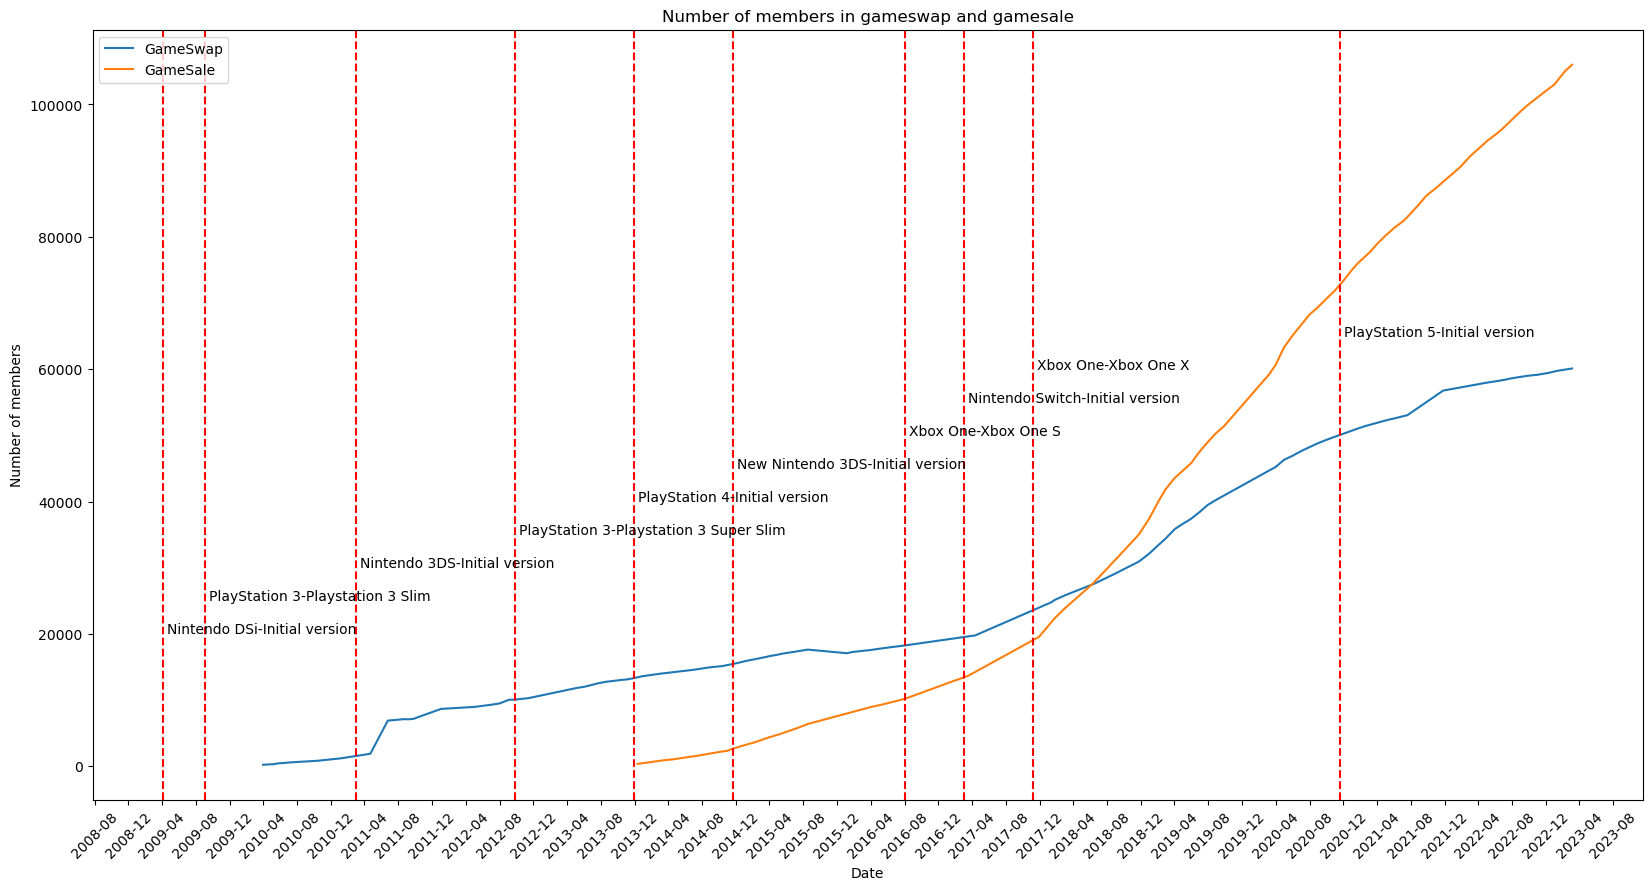

In [10]:
plt.figure(figsize=(20, 10))
# Plot the date and max_members
plt.plot([datetime.datetime.strptime(x[0], '%Y%m%d') for x in date_members_swap.items()], [x[1] for x in date_members_swap.items()], label='GameSwap')
plt.plot([datetime.datetime.strptime(x[0], '%Y%m%d') for x in date_members_sale.items()], [x[1] for x in date_members_sale.items()], label='GameSale')
# Mark the console date
for i in range(len(console_date_plot)):
    plt.axvline(x=datetime.datetime.strptime(console_date_plot['date'][i], '%Y%m%d'), color='r', linestyle='--')
    plt.text(datetime.datetime.strptime(console_date_plot['date'][i], '%Y%m%d')+datetime.timedelta(days=15), 5000*(i+4), console_date_plot.index[i], rotation=0)
# Set the title
plt.title('Number of members in gameswap and gamesale')
# Set the x-axis label and rotate the label
plt.xlabel('Date')
plt.xticks(rotation=45)
# Set the y-axis label
plt.ylabel('Number of members')
# Set the x-axis tick by month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
# Set the legend to the upper left
plt.legend(loc='upper left')
# No grid
plt.grid(False)
# Save the figure
plt.savefig('plot/swap_sale_console_release.png')
# Show the figure
plt.show()

## 2. Get the history of the confirmed transactions

In [11]:
if not os.path.exists('./data/history.pickle'):
    history_url = "https://raw.githubusercontent.com/RegExrTech/SwapBot/master/database/gamesale-swaps.json"
    history = requests.get(history_url).json()['reddit']
    # Save the dictionary
    with open('./data/history.pickle', 'wb') as handle:
        pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./data/history.pickle', 'rb') as handle:
        history = pickle.load(handle)

In [12]:
list(history.items())[:1]

[('mjwright412',
  ['acm1899 - https://www.reddit.com/r/gamesale/comments/4c34l2/-/d3n0hwa',
   'tearsofarapper84 - https://www.reddit.com/r/gamesale/comments/543odh/-/dbfktwo',
   'alohaanthony - https://www.reddit.com/r/mushroomkingdom/comments/f0tijf/-/foc4r1m',
   'pnguyen14 - https://www.reddit.com/r/mushroomkingdom/comments/f0tijf/-/fq3usla'])]

In [13]:
# Split by first - and return a tuple
def split_by_dash(string):
    return tuple(string.split(' - ', 1))


if not os.path.exists('./data/transformed_history.pickle'):
    # Processed data
    pattern = r"/r/(\w+)/"
    transformed_history = {}
    wrong_data = {}
    for key, value_list in history.items():
        for value in value_list:
            try:
                user, link = split_by_dash(value)
                # Use re to get the string between "r/" and "/" in the link
                _type = re.search(pattern, link).group(1)
                transformed_history.setdefault(key, []).append({
                    'user': user,
                    'link': link,
                    'type': _type
                })
            except ValueError:
                wrong_data.setdefault(key, []).append(value)
    with open('data/transformed_history.pickle', 'wb') as f:
        pickle.dump(transformed_history, f)
else:
    with open('data/transformed_history.pickle', 'rb') as f:
        transformed_history = pickle.load(f)

In [14]:
list(transformed_history.items())[0]

('mjwright412',
 [{'user': 'acm1899',
   'link': 'https://www.reddit.com/r/gamesale/comments/4c34l2/-/d3n0hwa',
   'type': 'gamesale'},
  {'user': 'tearsofarapper84',
   'link': 'https://www.reddit.com/r/gamesale/comments/543odh/-/dbfktwo',
   'type': 'gamesale'},
  {'user': 'alohaanthony',
   'link': 'https://www.reddit.com/r/mushroomkingdom/comments/f0tijf/-/foc4r1m',
   'type': 'mushroomkingdom'},
  {'user': 'pnguyen14',
   'link': 'https://www.reddit.com/r/mushroomkingdom/comments/f0tijf/-/fq3usla',
   'type': 'mushroomkingdom'}])

In [15]:
# This is the legacy trade.
# list(wrong_data.items())[:2]

### Get the concrete comment for each transaction.
Now we have the link to each confirmation of the transaction. The following code is to get the comment of each transaction.

In [16]:
# Get the comment using crawler
def get_comment(url, bot_name_to_crawl='my bot 3.1415'):
    # Need to change the bot name after a period of time.
    json_raw = requests.get(url+'.json', headers = {'User-agent': bot_name_to_crawl})
    try:
        _comment = json_raw.json()[1]['data']['children'][0]['data']
        sleep(0.15)
        return _comment
    except IndexError:
        return None

In [17]:
if not os.path.exists('./data/transformed_data.pickle'):
    start_time = time.time()
    i=0
    start = 0
    for key, value_list in list(transformed_data.items())[start:] :
        for value in value_list:
            if value.get('comment') is None:
                try:
                    value['comment'] = get_comment(value['link'])
                except Exception:
                    # Change the bot name after a while.
                    value['comment'] = get_comment(value['link'], 'my bot %d' % i)
        i+=1
        print(i, time.time() - start_time)
    # Save the dictionary
    with open('./data/transformed_data.pickle', 'wb') as handle:
        pickle.dump(transformed_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./data/transformed_data.pickle', 'rb') as handle:
        transformed_data = pickle.load(handle)

In [18]:
# A sample
for key, value_list in transformed_data.items():
    print(key)
    print(value_list[0].get('comment').get('body'))
    print(value_list[0].get('comment').get('replies').get('data')['children'][0]['data'].get('body'))
    break

mjwright412
Sold Mario Kart Double Dash to /u/mjwright412 https://www.reddit.com/r/GameSale/comments/4hdn0z/h_paypal_w_2_gamecube_controllers_mario_games/d2p7lud
Confirmed!


### Simplify the dictionary.

# This needs to be rewritten.
Need to go through the reply thread to find the real reply_author.

https://www.reddit.com/r/mushroomkingdom/comments/l6narh/comment/gyh2mbn/
In this case, the reply will only get the author but not the one confirming.

In [20]:
# For each comment, we want the following information:
# - author
# - body
# - created_utc
# - permalink
# - replies['data']['children'][0]['data']
keys = ['author', 'body', 'created_utc', 'permalink']
reply_keys = ['author', 'body']

simplified_data = {}
for key, value_list in transformed_data.items():
    for value in value_list:
        if value.get('comment') is not None:
            simplified_data.setdefault(key, []).append({k: value['comment'][k] for k in keys})
            try:
                '''
                This reply should be written using a new function.
                '''
                reply = value['comment']['replies']['data']['children'][0]['data']
                for reply_key in reply_keys:
                    if reply.get(reply_key) is not None:
                        simplified_data[key][-1].setdefault('reply_%s'%reply_key,  reply[reply_key])
            except Exception:
                pass


flatten_dict = {}
for key, value_list in simplified_data.items():
    for index, value in enumerate(value_list):
        flatten_dict.setdefault(key+"_%d" % index,value)
        
df = pd.DataFrame(flatten_dict).T
df.reset_index(inplace=True)

# Transform to human-readable time
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

pattern = r"/r/(\w+)/"
df['type'] = df['permalink'].apply(lambda x: re.search(pattern, x).group(1).lower())

# Store the dataframe using pickle
# df.to_pickle('./data/df.pickle')

In [21]:
df.loc[:5,['author','body','reply_author','reply_body','type','created_utc']]

,author,body,reply_author,reply_body,type,created_utc
0,ACM1899,Sold Mario Kart Double Dash to /u/mjwright412 ...,mjwright412,Confirmed!,gamesale,2016-05-28 15:24:00
1,TearsOfARapper84,Successful sale of Watch Dogs 2 Gold Edition P...,mjwright412,"Confirmed. Awesome person, no hassle and would...",gamesale,2016-12-20 18:37:19
2,mjwright412,Bought an Xbox One S 500GB and 2 controllers f...,AlohaAnthony,"Yes, I can confirm. Transition went smooth. ht...",mushroomkingdom,2020-04-23 18:38:10
3,pnguyen14,Sold Person 4 Arena to u/mjwright412 for $20 s...,mjwright412,Confirmed,mushroomkingdom,2020-05-10 00:28:52
4,Barbecue_Wings,Successfull swap of Rocket League on XB1 for $...,rdmentalist,"Confirmed, thanks",gamesale,2016-08-30 16:31:14
5,wilbursmith22,Completed trade with u/rdmentalist\n\nLast Gua...,rdmentalist,"Confirmed, thanks",gamesale,2017-06-30 22:40:47


In [22]:
# Get the rows reply_author is null
check_null = df[df['reply_author'].isnull()]
check_null.head(5)[['author','body','reply_author','reply_body','type','created_utc']]

,author,body,reply_author,reply_body,type,created_utc
21,SwapNSalebot,\n**It's dangerous to go alone! Take this.**\n...,NaN,NaN,gamesale,2021-10-08 16:33:56
83,whatisrealiwonder,Traded my sonic mania for u/gaugeforever diabl...,NaN,NaN,mushroomkingdom,2020-09-29 17:48:36
97,SwapNSalebot,\n**It's dangerous to go alone! Take this.**\n...,NaN,NaN,gamesale,2021-07-26 18:29:50
98,SwapNSalebot,\n**It's dangerous to go alone! Take this.**\n...,NaN,NaN,gamesale,2021-10-15 13:26:38
99,SwapNSalebot,\n**It's dangerous to go alone! Take this.**\n...,NaN,NaN,gamesale,2021-11-06 01:45:39


### Plot the trends for the three communities.

<Figure size 640x480 with 0 Axes>

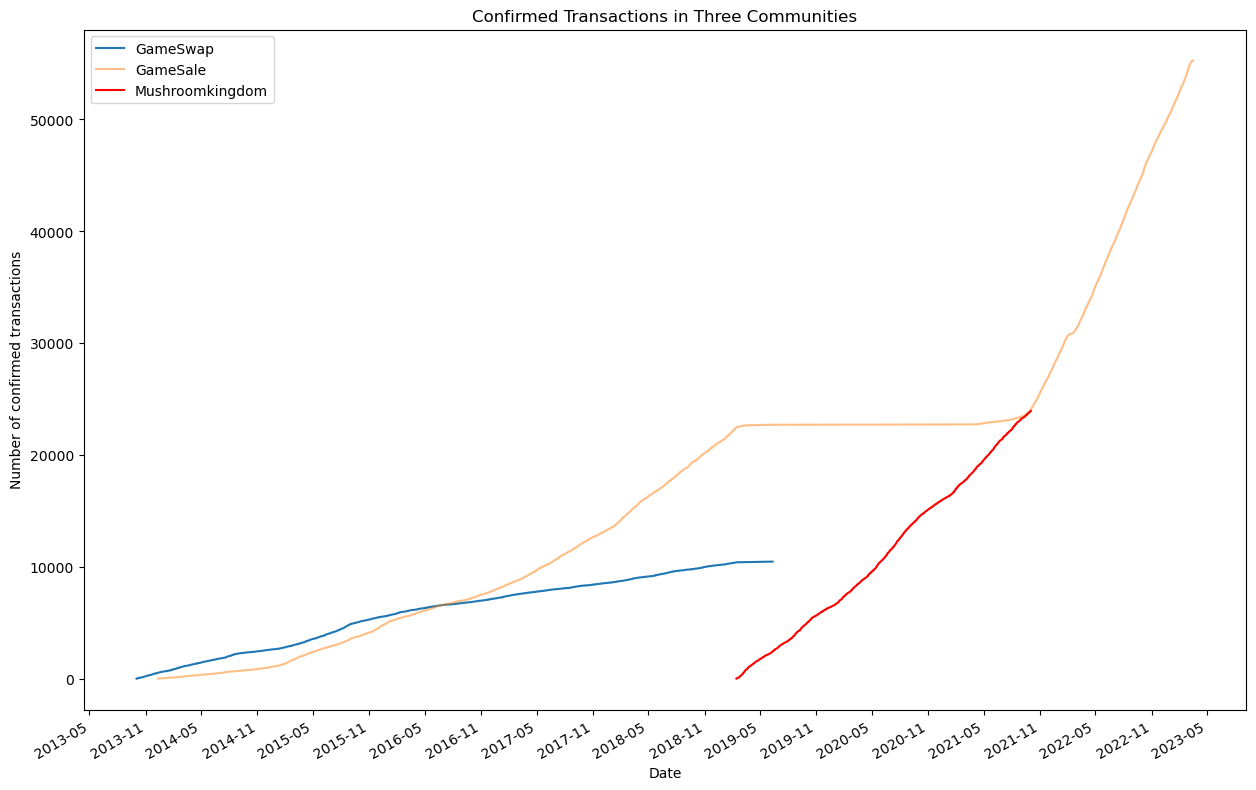

In [24]:
# Get the cumulative sum of the number of transactions per day of type 'gameswap'
plt.clf()
plt.figure(figsize=(15, 10))
df[df['type'] == 'gameswap'].groupby('created_utc').count()['index'].cumsum().plot()
df[df['type'] == 'gamesale'].groupby('created_utc').count()['index'].cumsum().plot(alpha=0.5)
df[df['type'] == 'mushroomkingdom'].groupby('created_utc').count()['index'].cumsum().plot(color='red')
plt.legend(['GameSwap', 'GameSale', 'Mushroomkingdom'])
plt.xlabel('Date')
plt.ylabel('Number of confirmed transactions')
plt.title('Confirmed Transactions in Three Communities')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.savefig('plot/confirmed_preprocess.png',dpi=300)
plt.show()


### Create training dataset using gameswap and gamesale
Mushroomkingdom is a subreddit community that is used to post confirmation for both the gameswap and gamesale communities. So we need to extract the actual type of transaction from mushroomkingdom.

In [23]:
# Training data with type not equal to 'mushroomkingdom' with columns ['body', 'type']
df_train = df[(df['type'] != 'mushroomkingdom') & (df['author']!= 'SwapNSalebot')][['body', 'type']]
# Remove the rows with body is '[deleted]' or '[removed]'
df_train = df_train[~df_train['body'].isin(['[deleted]', '[removed]'])]
# Store it in pickle
if not os.path.exists('./data/train_data.pickle'):
    with open('./data/train_data.pickle', 'wb') as handle:
        pickle.dump(df_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
df_train

,body,type
0,Sold Mario Kart Double Dash to /u/mjwright412 ...,gamesale
1,Successful sale of Watch Dogs 2 Gold Edition P...,gamesale
4,Successfull swap of Rocket League on XB1 for $...,gamesale
5,Completed trade with u/rdmentalist\n\nLast Gua...,gamesale
6,Successful trade with u/rdmentalist. Gave Gear...,gameswap
...,...,...
89661,Trade Completed With: u/Seeldoger47 Item(s) Tr...,gamesale
89662,Trade Completed With: u/3GSid Item(s) Traded: ...,gamesale
89663,Successful transaction with /u/sam_plus_plus\n...,gamesale
89664,My The Last Guardian brand new for /u/Moonstac...,gamesale
